In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch
import numpy as np
import pandas as pd
import collections as col

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')

In [99]:
oak_dir = '/oak/stanford/groups/rbaltman'
results_dir = os.path.join(oak_dir, 'protein_data_bias/results/Task1')

In [100]:
pdb_to_method = pd.read_csv(os.path.join(oak_dir, 'protein_data_bias/pdb_to_method_fixed.csv'))
pdb_to_method['pdb_id'] = pdb_to_method['IDCODE'].str.lower()
pdb_to_method.head()

,IDCODE,EXPERIMENT TYPE,pdb_id
0,100D,X-RAY DIFFRACTION,100d
1,101D,X-RAY DIFFRACTION,101d
2,101M,X-RAY DIFFRACTION,101m
3,102D,X-RAY DIFFRACTION,102d
4,102L,X-RAY DIFFRACTION,102l


In [101]:
pdb_method_dict = dict(zip(pdb_to_method['pdb_id'], pdb_to_method['EXPERIMENT TYPE']))

In [102]:
new = pd.read_csv(os.path.join(results_dir, 'gvp_xray_only_results_all.csv'))
original = pd.read_csv(os.path.join(results_dir, 'gvp_original_results_all.csv'))
df = pd.concat([original, new])
df['split'] = ['Train: Mixed']*len(original) + ['Train: Xray']*len(new)
df['pdb_id'] = df['name'].str[:4]

In [103]:
set(original.name) == set(new.name) # test sets contain same chains

True

In [104]:
df_method = pd.merge(df, pdb_to_method, on='pdb_id')
df_method = df_method[df_method['EXPERIMENT TYPE'].isin(['X-RAY DIFFRACTION', 'SOLUTION NMR', 'ELECTRON MICROSCOPY'])]
df_method.head()

,name,recovery,perplexity,split,pdb_id,IDCODE,EXPERIMENT TYPE
0,1a1t.A,0.419636,4.895802,Train: Mixed,1a1t,1A1T,SOLUTION NMR
1,1a1t.A,0.254364,13.532113,Train: Xray,1a1t,1A1T,SOLUTION NMR
2,1a1x.A,0.351481,6.855000,Train: Mixed,1a1x,1A1X,X-RAY DIFFRACTION
3,1a1x.A,0.353889,5.744984,Train: Xray,1a1x,1A1X,X-RAY DIFFRACTION
4,1a73.A,0.350184,7.009030,Train: Mixed,1a73,1A73,X-RAY DIFFRACTION


In [105]:
color_dict = dict(zip(range(6), [sns.color_palette('Paired')[9],sns.color_palette('Paired')[8],sns.color_palette('Paired')[3],sns.color_palette('Paired')[2],sns.color_palette('Paired')[7],sns.color_palette('Paired')[6]]))

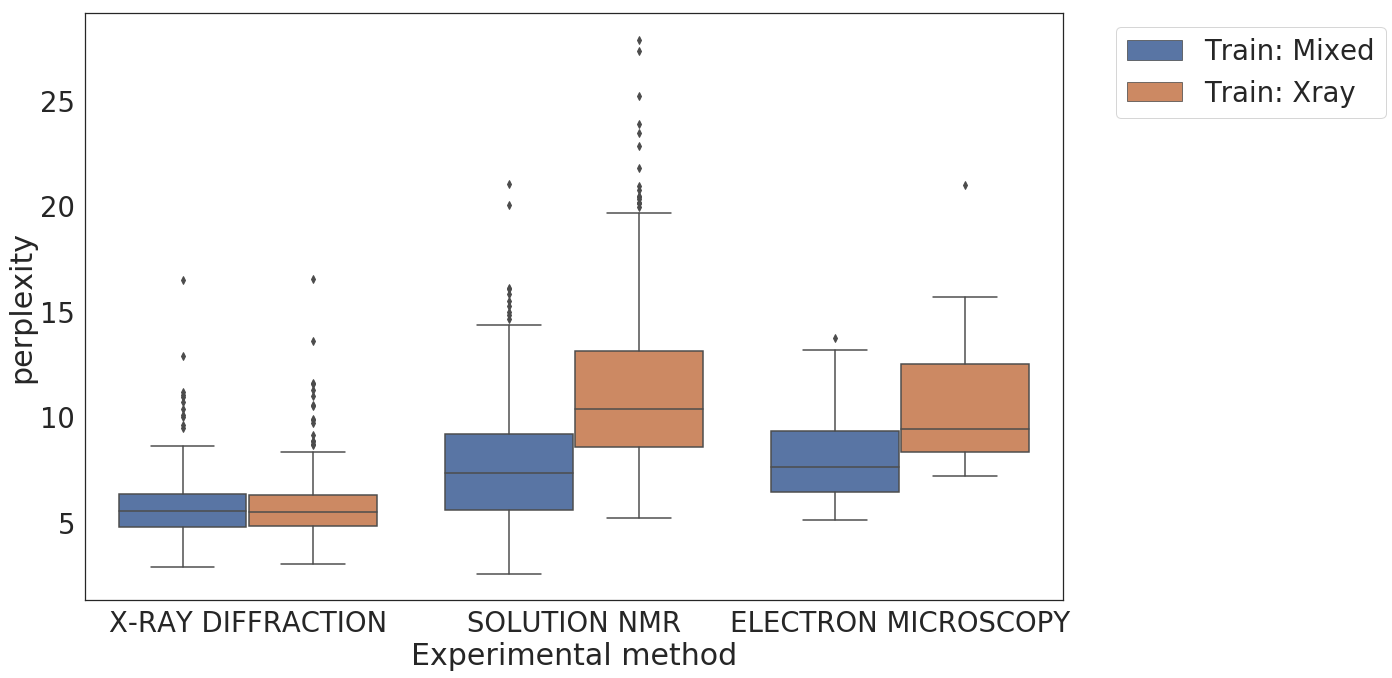

In [107]:
plt.rcParams.update({'font.size': 26})
plt.figure(figsize=(20,10))
ax = sns.boxplot(x='EXPERIMENT TYPE', y='perplexity', hue='split', data=df_method, order=['X-RAY DIFFRACTION', 'SOLUTION NMR', 'ELECTRON MICROSCOPY'])
# for i, box in enumerate(ax.artists):
#     box.set_facecolor(color_dict[i])
#     box.set_label()
# plt.title('Test set perplexity (GVP)')
plt.xlabel('Experimental method')
plt.legend(bbox_to_anchor=(1.04,1), loc=2)
plt.tight_layout()
plt.savefig('../figures/task1_perplexity_by_method.png', dpi=300)

Text(0.5, 1.0, 'Test set sequence recovery (GVP)')

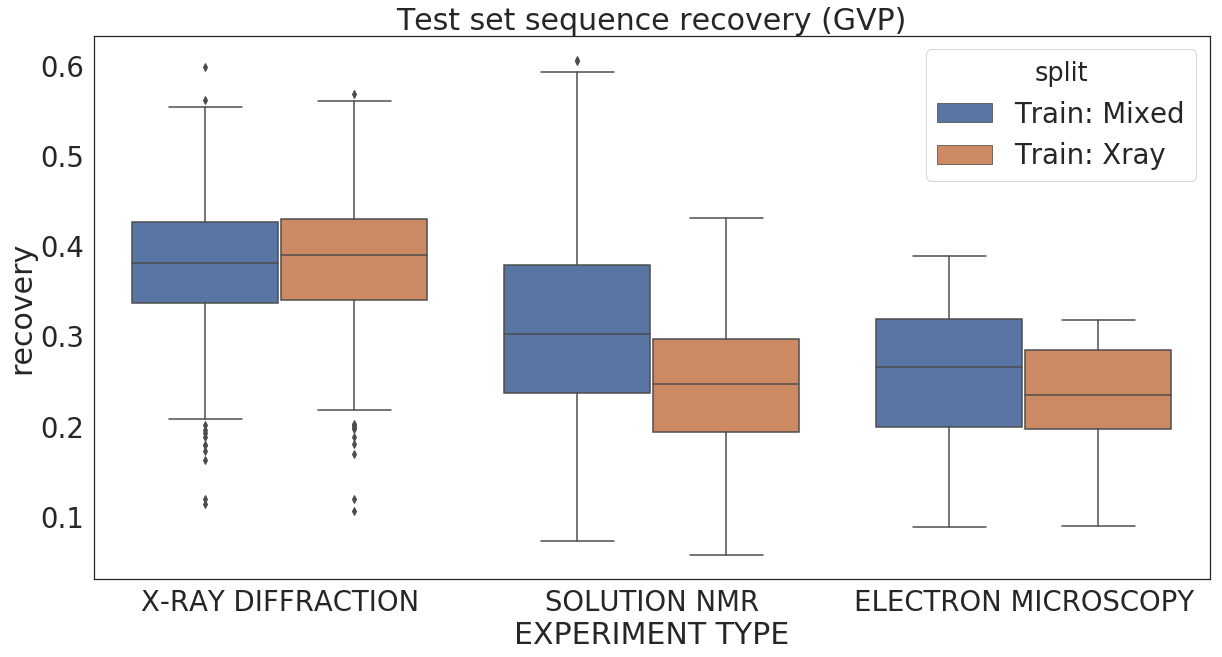

In [108]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(20,10))
sns.boxplot(x='EXPERIMENT TYPE', y='recovery', hue='split', data=df_method, order=['X-RAY DIFFRACTION', 'SOLUTION NMR', 'ELECTRON MICROSCOPY'], )
plt.title('Test set sequence recovery (GVP)')

In [109]:
from scipy.stats import mannwhitneyu, ttest_ind

n_hypotheses = 9
    
print('PERPLEXITY')
g = df_method.groupby('EXPERIMENT TYPE')
for name, group in g: 
    orig = group.query('split == "Train: Mixed"')['perplexity']
    new = group.query('split != "Train: Mixed"')['perplexity']
    p = mannwhitneyu(orig, new)[1] * n_hypotheses
    print(name, p)

g = df_method.groupby('split')
for name, group in g: 
    x = group.query('`EXPERIMENT TYPE` == "X-RAY DIFFRACTION"')['perplexity']
    n = group.query('`EXPERIMENT TYPE` == "SOLUTION NMR"')['perplexity']
    e = group.query('`EXPERIMENT TYPE` == "ELECTRON MICROSCOPY"')['perplexity']
    p = mannwhitneyu(x, n)[1] * n_hypotheses
    print(name + ': X-ray/NMR', p)
    p = mannwhitneyu(x, e)[1] * n_hypotheses
    print(name + ': X-ray/EM', p)
    p = mannwhitneyu(n, e)[1] * n_hypotheses
    print(name + ': NMR/EM', p)

PERPLEXITY
ELECTRON MICROSCOPY 0.08322723188815474
SOLUTION NMR 2.1936940926070326e-91
X-RAY DIFFRACTION 3.8199277057353798
Train: Mixed: X-ray/NMR 1.4166950731733663e-30
Train: Mixed: X-ray/EM 1.8335418202459533e-05
Train: Mixed: NMR/EM 1.6080037102566762
Train: Xray: X-ray/NMR 1.1951019027470781e-123
Train: Xray: X-ray/EM 2.9152938859059245e-09
Train: Xray: NMR/EM 1.7897724911910495


Evaluate paired structures from Mei et al.

In [110]:
new = pd.read_csv(os.path.join(results_dir, 'gvp_xray_only_results_paired.csv'))
original = pd.read_csv(os.path.join(results_dir, 'gvp_original_results_paired.csv'))
df = pd.concat([original, new])
df['split'] = ['Train: Mixed']*len(original) + ['Train: Xray']*len(new)
df['pdb_id'] = df['name'].str[:4]

In [111]:
df_method = pd.merge(df, pdb_to_method, on='pdb_id')
df_method = df_method[df_method['EXPERIMENT TYPE'].isin(['X-RAY DIFFRACTION', 'SOLUTION NMR', 'ELECTRON MICROSCOPY'])]
df_method.head()

,name,recovery,perplexity,split,pdb_id,IDCODE,EXPERIMENT TYPE
0,1jbh,0.278889,8.147282,Train: Mixed,1jbh,1JBH,SOLUTION NMR
1,1jbh,0.289333,10.178517,Train: Xray,1jbh,1JBH,SOLUTION NMR
2,1bu9,0.251012,9.130188,Train: Mixed,1bu9,1BU9,SOLUTION NMR
3,1bu9,0.196488,15.379972,Train: Xray,1bu9,1BU9,SOLUTION NMR
4,1z2d,0.383094,6.918709,Train: Mixed,1z2d,1Z2D,SOLUTION NMR


In [112]:
nmr_paired = ['1jbh','1bu9','1z2d','2aas','1t3v','1b4m','2kl2','2ka0','2msn','2y4w','1oca','1zgg','1g7o','2mpb','1ael','1wfr','2l59','2nln','2lsu','2i9h','1f16']
xray_paired = ['1crb','1ibh', '1jl3','1kf5', '1o13', '1opa', '1vkb','1zx8','2go7','2yb6','3k0m','4kk3','4kx4','4oa3','1ifc','2cx7','2i1u','1rro','4cgq','3f3q','4s0o']

In [113]:
names = ['RBP1', 'CDKN6', 'ARSC', 'RNS1', 'TM1816', 'RBP2', 'A2LD1', 'TM1367', 'SP_2064', 'UBE2B', 'CYPA', 'YWLE', 'GRX2', 'BA42', 'FABP2', 'TT1886', 'TRXA', 'OCM', 'TAH1', 'TRX1', 'BAX']

In [114]:
diffs = []
diff_names = []
for xray, nmr, name in zip(xray_paired, nmr_paired, names):
    try:
        diff = df_method[df_method['name']==xray].iloc[0,2] - df_method[df_method['name']==nmr].iloc[0,2]
    except:
        continue
    diffs.append(diff)
    diff_names.append(name)
np.mean(diffs), np.std(diffs)

(-3.259424033917879, 2.012144046883397)

In [115]:
paired_df = pd.DataFrame({'Protein': diff_names, 'Difference in Perplexity':diffs})

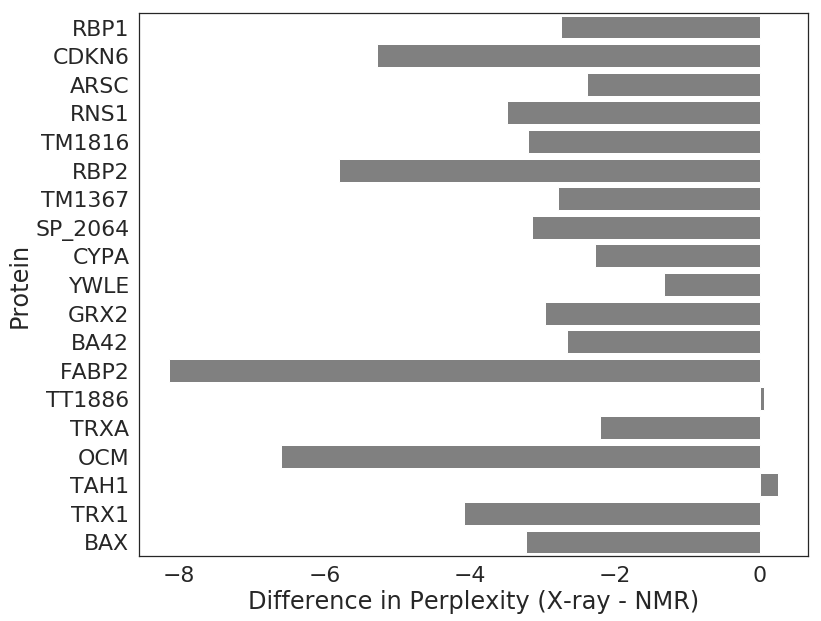

In [116]:
sns.set(style='white', font_scale=2)
plt.figure(figsize=(12,10))
sns.barplot('Difference in Perplexity', 'Protein', data=paired_df, orient='h', color='gray')
plt.xlabel('Difference in Perplexity (X-ray - NMR)')
plt.savefig('../figures/supp-paired.png', dpi=300)

#### Breakdown of results by amino acid, CATH, etc

In [226]:
letter_to_num = {'C': 4, 'D': 3, 'S': 15, 'Q': 5, 'K': 11, 'I': 9,
                       'P': 14, 'T': 16, 'F': 13, 'A': 0, 'G': 7, 'H': 8,
                       'E': 6, 'L': 10, 'R': 1, 'W': 17, 'V': 19, 
                       'N': 2, 'Y': 18, 'M': 12}
num_to_letter = {v:k for k, v in letter_to_num.items()}

In [ ]:
res_group_dict={
    'HIS':'positive','LYS':'positive','ARG':'positive',
    'ASP':'negative','GLU':'negative',
    'SER':'small_polar','THR':'small_polar','ASN':'small_polar','GLN':'small_polar',
    'ALA': 'small_hydrophobic', 'VAL':'small_hydrophobic', 'LEU':'small_hydrophobic', 'ILE':'small_hydrophobic', 'MET':'small_hydrophobic',
    'PHE':'large_hydrophobic', 'TYR':'large_hydrophobic','TRP':'large_hydrophobic',
    'PRO':'unique','GLY':'unique',
    'CYS':'cysteine'
    }

In [300]:
num_group_reorder = {8:0, 11:1, 1:2, 3:3, 6:4, 15:5, 16:6, 2:7, 5:8, 0:9, 19:10, 10:11, 9:12, 12:13, 13:14, 18:15, 17:16, 14:17, 7:18, 4:19}

In [227]:
new_seq = torch.load(os.path.join(results_dir, 'gvp_xray_only_sequences_all.pt'), map_location='cpu')
original_seq = torch.load(os.path.join(results_dir, 'gvp_original_sequences_all.pt'), map_location='cpu')

In [228]:
new_seq.keys()

dict_keys(['proteins', 'sequences', 'predicted', 'recovery'])

In [234]:
def recovery_by_aa(seqdict, method):
    aa_counts = col.defaultdict(int)
    aa2recovery = col.defaultdict(list)
    for i, protein in enumerate(seqdict['proteins']):
        if pdb_method_dict.get(protein[:4]) != method:
            continue
        seq = seqdict['sequences'][i]
        pred = seqdict['predicted'][i]
        recovery = seqdict['recovery'][i]
        for j, aa in enumerate(seq):
            aa2recovery['aa'].append(aa)
            aa2recovery['recovery'].append(recovery[j])
            aa2recovery['pred'].append(pred[j].argmax())
            aa_counts[aa] += 1
#     aa2recovery_avg = {k:v/aa_counts[k] for k,v in aa2recovery.items()}
    return pd.DataFrame(aa2recovery)

In [235]:
original_xray = recovery_by_aa(original_seq, 'X-RAY DIFFRACTION')
new_xray = recovery_by_aa(new_seq, 'X-RAY DIFFRACTION')
original_nmr = recovery_by_aa(original_seq, 'SOLUTION NMR')
new_nmr = recovery_by_aa(new_seq, 'SOLUTION NMR')

In [236]:
original_xray

,aa,recovery,pred
0,0,0.00,12
1,7,1.00,7
2,6,0.00,15
3,3,0.67,2
4,19,0.31,19
...,...,...,...
63963,8,0.07,6
63964,1,0.00,10
63965,6,0.53,6
63966,1,0.00,6


In [277]:
orig_combined = pd.concat([original_xray, original_nmr])
new_combined = pd.concat([new_xray, new_nmr])

In [278]:
all_diffs = new_combined.copy()

In [279]:
all_diffs['difference'] = orig_combined.recovery - new_combined.recovery

In [280]:
all_diffs['method'] = ['X-Ray Diffraction']*len(original_xray) + ['Solution NMR']*len(original_nmr)

In [281]:
all_diffs['Amino Acid'] = all_diffs.aa.apply(lambda x: num_to_letter[x])

In [282]:
all_diffs.head()

,aa,recovery,pred,difference,method,Amino Acid
0,0,0.06,6,-0.06,X-Ray Diffraction,A
1,7,1.00,7,0.00,X-Ray Diffraction,G
2,6,0.07,16,-0.07,X-Ray Diffraction,E
3,3,0.00,2,0.67,X-Ray Diffraction,D
4,19,0.79,19,-0.48,X-Ray Diffraction,V


In [123]:
# nmr_diff

array([ 0.03800933,  0.0431746 , -0.00893584,  0.00355153,  0.12951158,
       -0.00190433,  0.10988432,  0.06892185,  0.07123537,  0.01574148,
        0.03610126,  0.19016335,  0.0085847 ,  0.00220756,  0.15355138,
        0.17083767, -0.01283056,  0.04236458,  0.07756017,  0.03973898])

In [124]:
# full_df = pd.DataFrame({'Amino Acid': [num_to_letter[x[0]] for x in original_xray]*2, 'Difference in Recovery': list(xray_diff)+list(nmr_diff), 'method': ['X-RAY DIFFRACTION']*len(xray_diff) + ['SOLUTION NMR']*len(nmr_diff)})

In [125]:
# aa_order = [num_to_letter[x] for x in np.argsort(-nmr_diff)]

In [213]:
aa_order = all_diffs[all_diffs['method']=='Solution NMR'].groupby('Amino Acid').mean().difference.sort_values(ascending=False).index

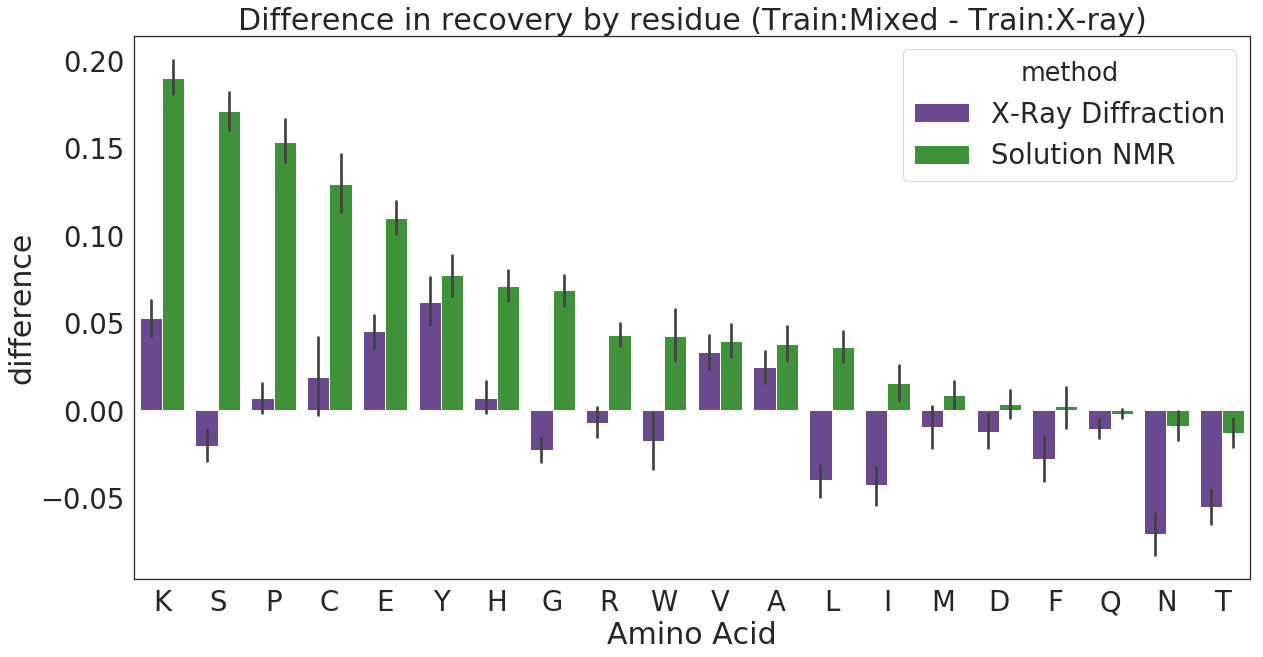

In [214]:
sns.set(style='white', font_scale=2.5)
plt.figure(figsize=(20,10))
sns.barplot(x='Amino Acid', y='difference', hue='method', data=all_diffs, palette=[sns.color_palette('Paired')[9],sns.color_palette('Paired')[3]], order=aa_order)
plt.title('Difference in recovery by residue (Train:Mixed - Train:X-ray)')
plt.savefig('../figures/task1_recovery_by_aa.png', dpi=300)

In [283]:
xray_diffs = all_diffs[all_diffs.method == 'X-Ray Diffraction']

In [302]:
cm = np.zeros((20, 20))
for i in range(xray_diffs.shape[0]):
    cm[num_group_reorder[xray_diffs.aa.tolist()[i]], num_group_reorder[xray_diffs.pred.tolist()[i]]] += 1

In [303]:
cm_norm = cm / cm.sum(axis=1)[:, np.newaxis]
per_class_accuracies = cm_norm.diagonal().tolist()

In [304]:
labels = [num_to_letter[x] for x in num_group_reorder.keys()]

In [309]:
def plot_cm(cm, labels, name=None):
    cm_norm = cm / np.sum(cm, -1)
    plt.clf()
    fig, ax = plt.subplots(figsize=(20,15))
    im = ax.imshow(cm_norm)
    ax.grid(False)
    # We want to show all ticks...
    ax.set_xticks(np.arange(len(cm))) #farmers)))
    ax.set_yticks(np.arange(len(cm))) #vegetables)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(list(labels), fontsize=14)
    ax.set_yticklabels(list(labels), fontsize=14)
    ax.set_xlabel('Predicted', fontsize=16)
    ax.set_ylabel('Actual', fontsize=16)
    
    for i in range(len(cm)):
        for j in range(len(cm)):
            if i == j:
                text = ax.text(j, i, round(cm_norm[i, j],2) ,
                           ha="center", va="center", color="black", fontsize=16)
    if name:
        plt.savefig(f'../figures/{name}.png', dpi=300)
    plt.show()

<Figure size 432x288 with 0 Axes>

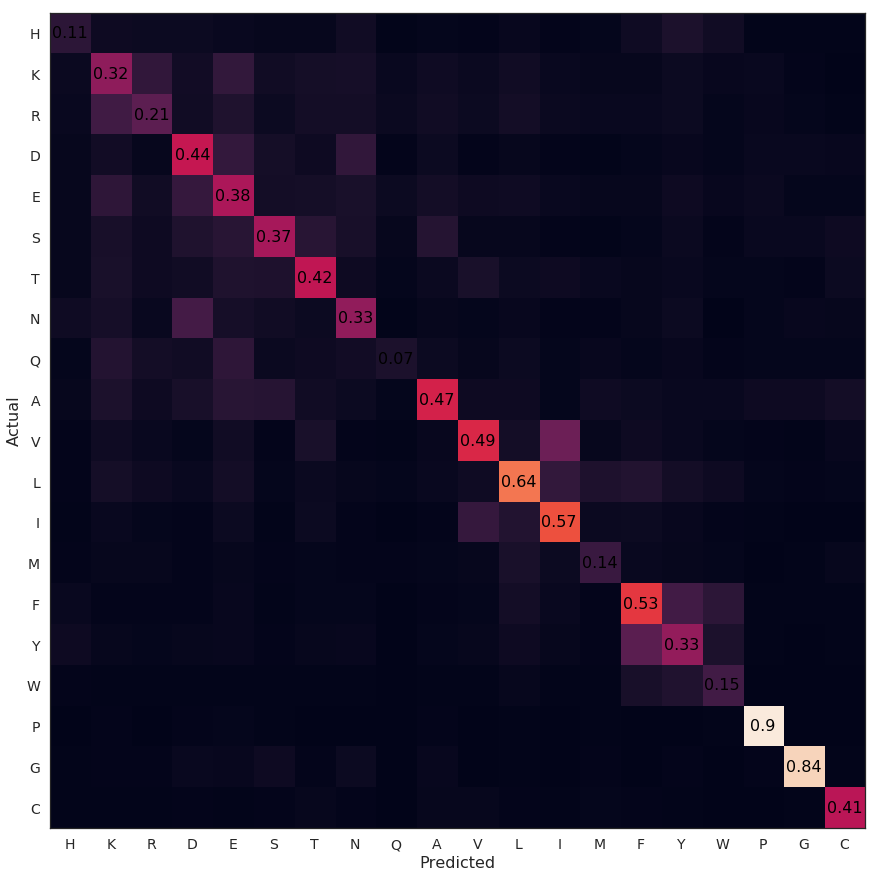

In [310]:
plot_cm(cm, labels, 'supp-confusion')

In [299]:
sorted(zip(labels, cm_norm[letter_to_num['S']]), key=lambda x: x[1], reverse=True)

[('S', 0.3677274987568374),
 ('A', 0.10467429139731477),
 ('E', 0.10193933366484337),
 ('T', 0.09273993038289408),
 ('D', 0.06663351566384883),
 ('K', 0.05494778717056191),
 ('N', 0.04226752859273993),
 ('R', 0.027598209845847838),
 ('G', 0.026106414719045252),
 ('L', 0.023868722028841372),
 ('V', 0.018647439085032323),
 ('P', 0.015166583789159622),
 ('Y', 0.014420686225758329),
 ('I', 0.009448035803083043),
 ('F', 0.00870213823968175),
 ('Q', 0.008204873197414222),
 ('C', 0.0072103431128791645),
 ('H', 0.005718547986076579),
 ('M', 0.0022376926902038788),
 ('W', 0.00174042764793635)]

In [127]:
import json
with open('./ingraham_splits.json') as f:
    ingraham_splits = json.load(f)

In [128]:
pdb_cath = ingraham_splits['cath_nodes']

In [129]:
all_cath = set()
for i, protein in enumerate(new_seq['proteins']):
    cath = pdb_cath[protein]
    for c in cath:
#         all_cath.add(c.split('.')[0])
        all_cath.add('.'.join(c.split('.')[:-1]))

In [130]:
all_cath

{'1.10',
 '1.20',
 '1.50',
 '2.10',
 '2.100',
 '2.102',
 '2.130',
 '2.150',
 '2.160',
 '2.170',
 '2.20',
 '2.30',
 '2.40',
 '2.60',
 '2.70',
 '3.10',
 '3.15',
 '3.20',
 '3.30',
 '3.40',
 '3.50',
 '3.55',
 '3.60',
 '3.70',
 '3.80',
 '3.90',
 '4.10'}

In [131]:
def recovery_by_cath(seqdict):
    cath_counts = col.defaultdict(int)
    cath2recovery = col.defaultdict(float)
    recoveries = []
    caths = []
    methods = []
    for i, protein in enumerate(seqdict['proteins']):
        cath = pdb_cath[protein]
        meth = pdb_method_dict.get(protein[:4])
        if meth not in ['X-RAY DIFFRACTION', 'SOLUTION NMR']:
            continue
        for ca in cath:
            ca = ca.split('.')[0]
            recovery = seqdict['recovery'][i]
            cath2recovery[ca] += recovery.sum()
            cath_counts[ca] += len(recovery)
            caths.append(ca)
            recoveries.append(recovery.mean())
            methods.append(meth)
    cath2recovery_avg = {k:v/cath_counts[k] for k,v in cath2recovery.items()}
    results = pd.DataFrame({'CATH class':caths, 'Recovery': recoveries, 'Method': methods})
    return results, sorted(cath2recovery_avg.items(), key=lambda x: x[0])

In [132]:
new_res, new_avg = recovery_by_cath(new_seq)
orig_res, orig_avg = recovery_by_cath(original_seq)

In [133]:
orig_res.groupby(['CATH class', 'Method']).count()

Recovery
CATH class Method                     
1          SOLUTION NMR            254
           X-RAY DIFFRACTION        62
2          SOLUTION NMR            157
           X-RAY DIFFRACTION        68
3          SOLUTION NMR            276
           X-RAY DIFFRACTION       204
4          SOLUTION NMR             77
           X-RAY DIFFRACTION        37

In [134]:
cath_names = {'1': 'Mainly Alpha', '2': 'Mainly Beta', '3': 'Alpha Beta', '4': 'Few Sec. Structures'}

In [135]:
all_res = pd.concat([orig_res, new_res])
all_res['split'] = ['Train: All']*len(orig_res) + ['Train: X-ray']*len(new_res)
all_res['cath_split'] = all_res['CATH class'].apply(lambda x: cath_names[x]) + ' / ' + all_res['split']

In [136]:
order = ['Mainly Alpha / Train: All', 'Mainly Alpha / Train: X-ray', 'Mainly Beta / Train: All', 'Mainly Beta / Train: X-ray', 'Alpha Beta / Train: All', 'Alpha Beta / Train: X-ray', 'Few Secondary Structures / Train: All', 'Few Secondary Structures / Train: X-ray']

In [137]:
shorthands = {'X-RAY DIFFRACTION': 'X-ray', 'SOLUTION NMR': 'NMR', 'ELECTRON MICROSCOPY': 'EM'}

In [138]:
all_res = pd.concat([orig_res, new_res])
all_res['split'] = ['Train: Mixed']*len(orig_res) + ['Train: X-ray']*len(new_res)
all_res['method_split'] = all_res['Method'].apply(lambda x: shorthands[x]) + ' / ' + all_res['split']
all_res['CATH class'] = all_res['CATH class'].apply(lambda x: cath_names[x])

In [139]:
order = ['X-ray / Train: Mixed', 'X-ray / Train: X-ray', 'NMR / Train: Mixed', 'NMR / Train: X-ray']

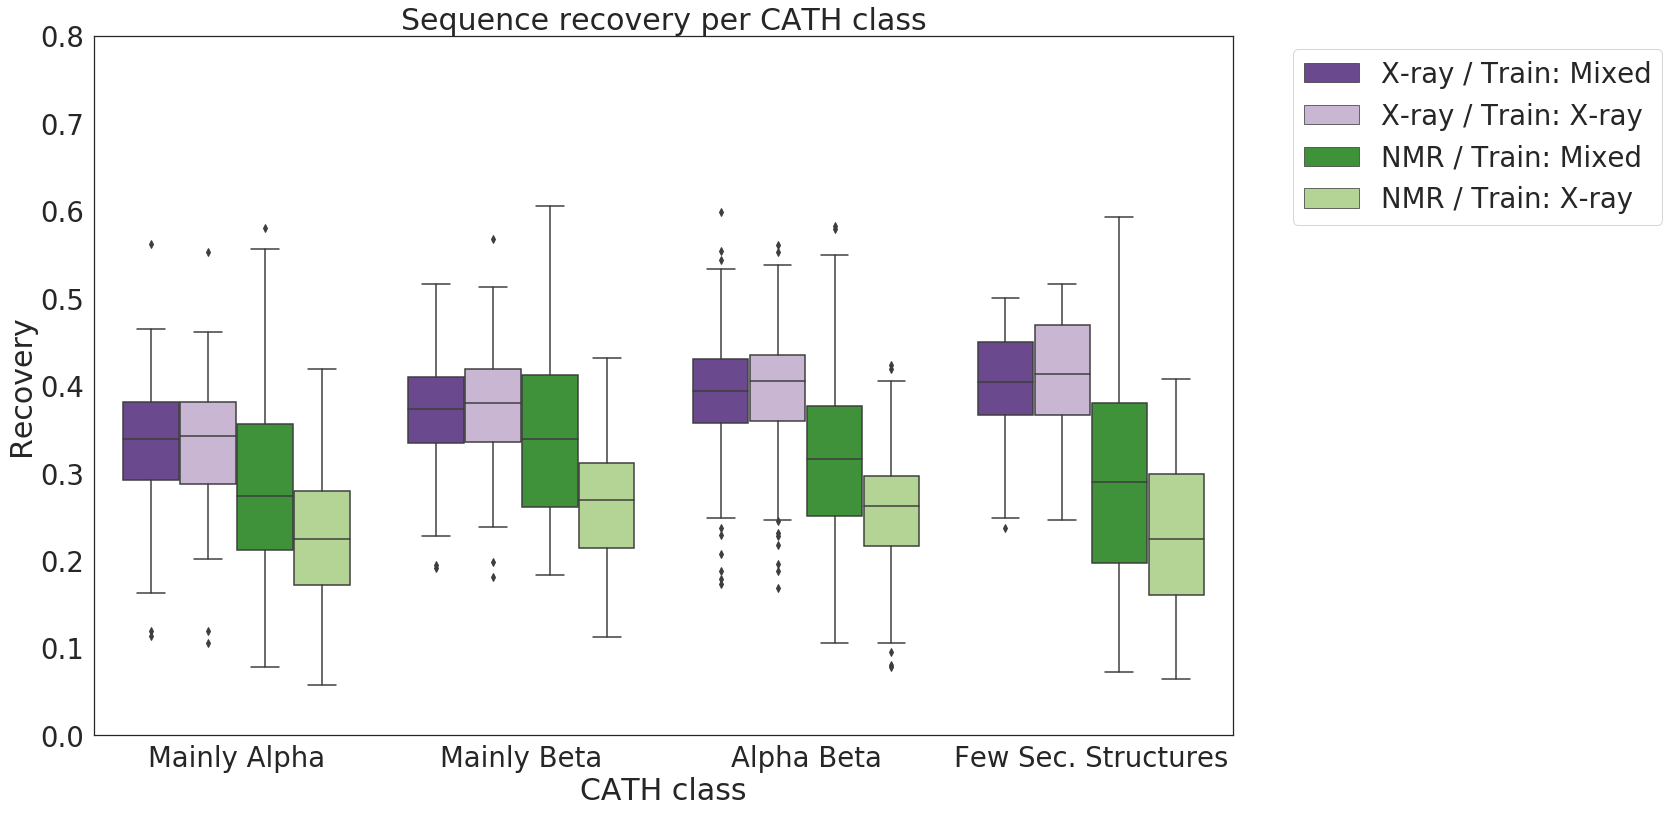

In [140]:
sns.set(style='white', font_scale=2.5)
fig, ax = plt.subplots(figsize=(24,12))
sns.boxplot(x='CATH class', y='Recovery', hue='method_split', data=all_res, ax=ax, hue_order=order, order=['Mainly Alpha', 'Mainly Beta', 'Alpha Beta', 'Few Sec. Structures'], palette=[sns.color_palette('Paired')[9], sns.color_palette('Paired')[8], sns.color_palette('Paired')[3], sns.color_palette('Paired')[2]])
plt.legend(bbox_to_anchor=(1.04,1),loc=2)
plt.ylim(0.0, 0.8)
plt.title('Sequence recovery per CATH class')
plt.tight_layout()
plt.savefig('../figures/task1_recovery_per_cath.png', dpi=300)

In [311]:
n_hyp = 24

In [141]:
xray_mixed_alpha = all_res.query("method_split == 'X-ray / Train: Mixed' & `CATH class` == 'Mainly Alpha'")['Recovery']
xray_xray_alpha = all_res.query("method_split == 'X-ray / Train: X-ray' & `CATH class` == 'Mainly Alpha'")['Recovery']
nmr_mixed_alpha = all_res.query("method_split == 'NMR / Train: Mixed' & `CATH class` == 'Mainly Alpha'")['Recovery']
nmr_xray_alpha = all_res.query("method_split == 'NMR / Train: X-ray' & `CATH class` == 'Mainly Alpha'")['Recovery']

In [312]:
from itertools import combinations
for l1,l2 in combinations(['xray_mixed_alpha', 'xray_xray_alpha', 'nmr_mixed_alpha', 'nmr_xray_alpha'],2):
    print(l1, l2)
    print(mannwhitneyu(eval(l1), eval(l2))[1]*n_hyp)

xray_mixed_alpha xray_xray_alpha
10.45174464321574
xray_mixed_alpha nmr_mixed_alpha
0.0017088978773799222
xray_mixed_alpha nmr_xray_alpha
6.309447316097058e-16
xray_xray_alpha nmr_mixed_alpha
0.0005778297643181376
xray_xray_alpha nmr_xray_alpha
1.921357570571049e-17
nmr_mixed_alpha nmr_xray_alpha
1.112008730758744e-09


In [143]:
xray_mixed_beta = all_res.query("method_split == 'X-ray / Train: Mixed' & `CATH class` == 'Mainly Beta'")['Recovery']
xray_xray_beta = all_res.query("method_split == 'X-ray / Train: X-ray' & `CATH class` == 'Mainly Beta'")['Recovery']
nmr_mixed_beta = all_res.query("method_split == 'NMR / Train: Mixed' & `CATH class` == 'Mainly Beta'")['Recovery']
nmr_xray_beta = all_res.query("method_split == 'NMR / Train: X-ray' & `CATH class` == 'Mainly Beta'")['Recovery']

In [313]:
from itertools import combinations
for l1,l2 in combinations(['xray_mixed_beta', 'xray_xray_beta', 'nmr_mixed_beta', 'nmr_xray_beta'],2):
    print(l1, l2)
    print(ttest_ind(eval(l1), eval(l2))[1]*n_hyp)

xray_mixed_beta xray_xray_beta
13.193513981315096
xray_mixed_beta nmr_mixed_beta
1.9778674046867017
xray_mixed_beta nmr_xray_beta
2.2366524089207604e-20
xray_xray_beta nmr_mixed_beta
0.587335383555835
xray_xray_beta nmr_xray_beta
2.2402864116557233e-22
nmr_mixed_beta nmr_xray_beta
1.7740764313680613e-13


In [145]:
xray_mixed_ab = all_res.query("method_split == 'X-ray / Train: Mixed' & `CATH class` == 'Alpha Beta'")['Recovery']
xray_xray_ab = all_res.query("method_split == 'X-ray / Train: X-ray' & `CATH class` == 'Alpha Beta'")['Recovery']
nmr_mixed_ab = all_res.query("method_split == 'NMR / Train: Mixed' & `CATH class` == 'Alpha Beta'")['Recovery']
nmr_xray_ab = all_res.query("method_split == 'NMR / Train: X-ray' & `CATH class` == 'Alpha Beta'")['Recovery']

In [314]:
from itertools import combinations
for l1,l2 in combinations(['xray_mixed_ab', 'xray_xray_ab', 'nmr_mixed_ab', 'nmr_xray_ab'],2):
    print(l1, l2)
    print(ttest_ind(eval(l1), eval(l2))[1]*n_hyp)

xray_mixed_ab xray_xray_ab
9.790975378197231
xray_mixed_ab nmr_mixed_ab
9.032313942702139e-18
xray_mixed_ab nmr_xray_ab
1.1209449594981129e-77
xray_xray_ab nmr_mixed_ab
2.4392560193672933e-20
xray_xray_ab nmr_xray_ab
4.357806278655189e-82
nmr_mixed_ab nmr_xray_ab
7.996054457215285e-20


In [147]:
xray_mixed_few = all_res.query("method_split == 'X-ray / Train: Mixed' & `CATH class` == 'Few Sec. Structures'")['Recovery']
xray_xray_few = all_res.query("method_split == 'X-ray / Train: X-ray' & `CATH class` == 'Few Sec. Structures'")['Recovery']
nmr_mixed_few = all_res.query("method_split == 'NMR / Train: Mixed' & `CATH class` == 'Few Sec. Structures'")['Recovery']
nmr_xray_few = all_res.query("method_split == 'NMR / Train: X-ray' & `CATH class` == 'Few Sec. Structures'")['Recovery']

In [315]:
from itertools import combinations
for l1,l2 in combinations(['xray_mixed_few', 'xray_xray_few', 'nmr_mixed_few', 'nmr_xray_few'],2):
    print(l1, l2)
    print(ttest_ind(eval(l1), eval(l2))[1]*n_hyp)

xray_mixed_few xray_xray_few
16.482323207588692
xray_mixed_few nmr_mixed_few
0.0002854903661183107
xray_mixed_few nmr_xray_few
1.044749345990203e-17
xray_xray_few nmr_mixed_few
8.899225684816934e-05
xray_xray_few nmr_xray_few
1.766383001734285e-18
nmr_mixed_few nmr_xray_few
0.003902376154508733


#### Evaluate subsampling X-ray structures

In [149]:
full = pd.read_csv(os.path.join(results_dir, 'gvp_xray_only_results_all.csv'))
full25 = pd.read_csv(os.path.join(results_dir, 'gvp_xray_only_25pct_results_all.csv'))
full50 = pd.read_csv(os.path.join(results_dir, 'gvp_xray_only_50pct_results_all.csv'))
full75 = pd.read_csv(os.path.join(results_dir, 'gvp_xray_only_75pct_results_all.csv'))

In [150]:
df = pd.concat([full25, full50, full75, full])
df['dataset size'] = [0.25]*len(full25) + [0.5]*len(full50)  + [0.75]*len(full75) + [1.0]*len(full)
df['pdb_id'] = df['name'].str[:4]

In [151]:
df_method = pd.merge(df, pdb_to_method, on='pdb_id')
df_method = df_method[df_method['EXPERIMENT TYPE'].isin(['X-RAY DIFFRACTION', 'SOLUTION NMR', 'ELECTRON MICROSCOPY'])]
df_method.head()

,name,recovery,perplexity,dataset size,pdb_id,IDCODE,EXPERIMENT TYPE
0,1a1t.A,0.193091,14.054339,0.25,1a1t,1A1T,SOLUTION NMR
1,1a1t.A,0.179455,12.490133,0.50,1a1t,1A1T,SOLUTION NMR
2,1a1t.A,0.236364,14.880410,0.75,1a1t,1A1T,SOLUTION NMR
3,1a1t.A,0.254364,13.532113,1.00,1a1t,1A1T,SOLUTION NMR
4,1a1x.A,0.316852,8.469994,0.25,1a1x,1A1X,X-RAY DIFFRACTION


In [152]:
full = pd.read_csv(os.path.join(results_dir, 'gvp_original_results_all.csv'))
full25 = pd.read_csv(os.path.join(results_dir, 'gvp_original_25pct_results_all.csv'))
full50 = pd.read_csv(os.path.join(results_dir, 'gvp_original_50pct_results_all.csv'))
full75 = pd.read_csv(os.path.join(results_dir, 'gvp_original_75pct_results_all.csv'))

In [153]:
df = pd.concat([full25, full50, full75, full])
df['dataset size'] = [0.25]*len(full25) + [0.5]*len(full50)  + [0.75]*len(full75) + [1.0]*len(full)
df['pdb_id'] = df['name'].str[:4]

In [154]:
df_method_orig = pd.merge(df, pdb_to_method, on='pdb_id')
df_method_orig = df_method_orig[df_method_orig['EXPERIMENT TYPE'].isin(['X-RAY DIFFRACTION', 'SOLUTION NMR', 'ELECTRON MICROSCOPY'])]
df_method_orig.head()

,name,recovery,perplexity,dataset size,pdb_id,IDCODE,EXPERIMENT TYPE
0,1a1x.A,0.282315,8.440988,0.25,1a1x,1A1X,X-RAY DIFFRACTION
1,1a1x.A,0.302870,7.937634,0.50,1a1x,1A1X,X-RAY DIFFRACTION
2,1a1x.A,0.313611,7.828370,0.75,1a1x,1A1X,X-RAY DIFFRACTION
3,1a1x.A,0.351481,6.855000,1.00,1a1x,1A1X,X-RAY DIFFRACTION
4,1a2p.A,0.417909,5.521381,0.25,1a2p,1A2P,X-RAY DIFFRACTION


In [155]:
# sns.set(style='white', font_scale=1.5)
# plt.figure(figsize=(20,10))
# sns.boxplot(x='EXPERIMENT TYPE', y='perplexity', hue='split', data=df_method_orig, order=['X-RAY DIFFRACTION', 'SOLUTION NMR', 'ELECTRON MICROSCOPY'], palette="Blues_r")
# plt.title('GVP perplexity by size of training set (X-ray only)')

In [156]:
df_both = pd.concat([df_method_orig, df_method])
df_both['split'] = ['Train: Mixed']*len(df_method_orig) +  ['Train: X-ray']*len(df_method)
df_both = df_both[df_both['EXPERIMENT TYPE'].isin(['X-RAY DIFFRACTION', 'SOLUTION NMR'])]

In [157]:
color_dict = dict(zip(range(4), [sns.color_palette('Paired')[9],sns.color_palette('Paired')[8],sns.color_palette('Paired')[3],sns.color_palette('Paired')[2]]))

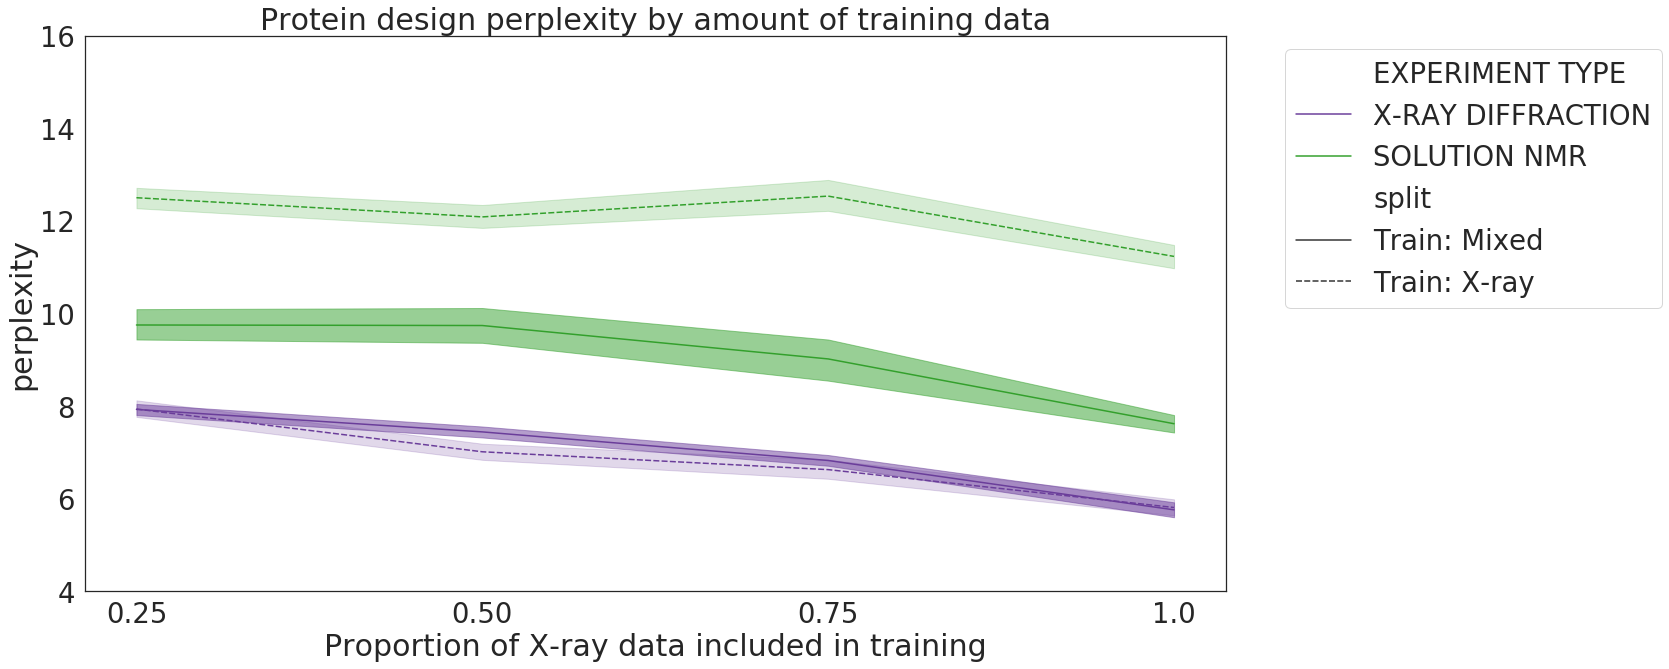

In [158]:
from matplotlib.collections import PolyCollection
sns.set(style='white', font_scale=2.5)
plt.figure(figsize=(24,10))
ax = sns.lineplot(x='dataset size', y='perplexity', hue='EXPERIMENT TYPE', data=df_both, style='split', hue_order=['X-RAY DIFFRACTION', 'SOLUTION NMR'], palette=[sns.color_palette('Paired')[9],sns.color_palette('Paired')[3]])
# for i, line in enumerate(ax.get_lines()[:4]):
#     line.set_color(color_dict[i])
for child in ax.findobj(PolyCollection)[::2]:
    child.set_alpha(0.5)
#     child.set_hatch('//')
plt.title('Protein design perplexity by amount of training data')
plt.ylim(4,16)
plt.xticks(np.arange(0.25,1.25,0.25), ['0.25','0.50','0.75','1.0'])
plt.xlabel('Proportion of X-ray data included in training')
plt.legend(bbox_to_anchor=(1.04,1),loc=2)
plt.tight_layout()
plt.savefig('../figures/task1_perplexity_by_size.png', dpi=300)